[View in Colaboratory](https://colab.research.google.com/github/adowaconan/Deep_learning_fMRI/blob/master/4_4_XGB_implementation.ipynb)

In [1]:
!pip install -U -q PyDrive
!pip install tqdm
!apt-get install swig
!pip install -U pymvpa2
!pip install -U seaborn

# this lets you access to googel drive shared files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# why not numpy?
import numpy as np
import zipfile
from sklearn.metrics import roc_auc_score


from glob import glob # useless
from tqdm import tqdm # maybe useful
import pickle # very useful
from collections import Counter # I'm a counter
from mvpa2.mappers.fx import mean_group_sample # pymvpa
from mvpa2.generators.partition import NFoldPartitioner # pymvpa
from mvpa2.base.node import ChainNode # pymvpa
from mvpa2.generators.resampling import Balancer # pymvpa
from mvpa2.generators.base import Sifter # pymvpa
from mvpa2.mappers.base import Mapper # pymvpa
from keras.layers import Dense,Dropout,BatchNormalization
from keras.layers import Input, AveragePooling3D,Reshape
from keras.layers import Conv2D,Conv2DTranspose
from keras.layers import GaussianNoise # add noise to our data
from keras.layers import Flatten,Dense,LeakyReLU,Conv3DTranspose
from keras.models import Model
import keras
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers
from sklearn import metrics
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

data_id = 'https://drive.google.com/open?id=1sMQh_8qhCwN7N1yM8mTEBT9m8q7l_0iv'.split('id=')[-1]
zip_import = drive.CreateFile({'id':data_id})
zip_import.GetContentFile('{}'.format('all_bin.pkl'))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 0 not upgraded.
Need to get 1,080 kB of archives.
After this operation, 5,657 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig3.0 amd64 3.0.10-1.2 [1,074 kB]
Get:2 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig amd64 3.0.10-1.2 [6,384 B]
Fetched 1,080 kB in 0s (1,085 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.10-1.2_amd64.deb ...
Unpacking swig3.0 (3.0.10-1.2) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.10-1.2_amd64.deb ...


Using TensorFlow backend.


# Read condition

## Experiment:

### Subjects in the sanner, and were instructed to read the word repeatedly as it was present. The words can be divided into 2 semantic categories: living animals and non-living tools

## words:

'llave', 'lapiz', 'tijera', 'aguja', 'pinza', 'sierra', 'clavo',
'pincel', 'alicate', 'tuerca', 'navaja', 'cepillo', 'taladro',
'soplete', 'tornillo', 'cuchara', 'martillo', 'cuchillo', 'tigre',
'gallo', 'perro', 'oveja', 'cerdo', 'gorila', 'burro', 'yegua',
'ardilla', 'conejo', 'gallina', 'caballo', 'ballena', 'pantera',
'camello', 'tortuga', 'elefante', 'canguro'
<br />**can you divide them?**

In [0]:
from IPython.display import Image
image_id = 'https://drive.google.com/open?id=1qZfXGiqtQ9g5DJsCtb_Injy_tSCEJ3dG'.split('id=')[-1]
image = drive.CreateFile({'id':image_id})
image.GetContentFile('{}'.format('words.png'))


In [0]:
dataset_ = pickle.load(open('all_bin.pkl','rb'))
dataset = dataset_[dataset_.sa.context == 'read']

In [4]:
print(dataset.summary())

Dataset: 1544x16130@float32, <sa: categories,chunks,context,id,targets,time_coords,time_indices,trials,words>, <fa: voxel_indices>, <a: imgaffine,imghdr,imgtype,mapper,voxel_dim,voxel_eldim>
stats: mean=8.95748e-10 std=0.993167 var=0.98638 min=-6.82599 max=6.5985

Counts of targets in each chunk:
  chunks\targets animal tool
                   ---   ---
        0          111   111
        2          110   111
        4          110   110
        6          108   115
        8          109   109
       10          108   110
       12          111   111

Summary for targets across chunks
  targets mean  std min max #chunks
  animal   110 1.18 108 111    7
   tool    111 1.77 109 115    7

Summary for chunks across targets
  chunks mean std min max #targets
    0     111  0  111 111     2
    2     110 0.5 110 111     2
    4     110  0  110 110     2
    6     112 3.5 108 115     2
    8     109  0  109 109     2
   10     109  1  108 110     2
   12     111  0  111 111     2
Sequence s

In [0]:
import xgboost as xgb


[A Gentle Introduction to XGBoost for Applied Machine Learning](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/)


https://www.kaggle.com/datacanary/xgboost-example-python

In [0]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score,StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import (classification_report,
                             matthews_corrcoef,
                             confusion_matrix,
                             f1_score,
                             log_loss)

# helper funtion
def get_blocks_metasema(dataset__,label_map):
    """
    # use ids, chunks,and labels to make unique blocks of the pre-average dataset, because I don't want to 
    # average the dataset until I actually want to, but at the same time, I want to balance the data for 
    # both the training and test set.
    
    Preparation for cross validation functions used in scit-kit learning
    """
    ids                 = dataset__.sa.id.astype(int)
    chunks              = dataset__.sa.chunks
    labels              = np.array([label_map[item] for item in dataset__.targets])[:,-1]
    sample_indecies     = np.arange(len(labels))
    blocks              = [np.array([ids[ids             == target],
                                     chunks[ids          == target], 
                                     labels[ids          == target],
                                     sample_indecies[ids == target]
                                     ]) for target in np.unique(ids)]
    block_labels        = np.array([np.unique(ll[-2]) for ll in blocks]).ravel()
    return blocks,block_labels
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold         = roc_curve(target, predicted)
    i                           = np.arange(len(tpr)) 
    roc                         = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t                       = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [7]:
average = True # average the instances before training the baseline model

scores = []
cfm    = []
weight = []
label_map = dict(animal  = [0,1],
                 tool    = [1,0])
blocks, block_labels = get_blocks_metasema(dataset,label_map)
cv = StratifiedShuffleSplit(n_splits     = 30,# random partition 30 times, but ideally, we need 100 or more
                            test_size    = 0.2, # 20 % as the test data
                            random_state = 12345 # for reproducibility purpose
                           )
for fold, (train,test) in enumerate(cv.split(blocks,block_labels)):
    idx_train = np.concatenate([blocks[tr_element][-1] for tr_element in train])
    idx_test  = np.concatenate([blocks[te_element][-1] for te_element in test ])
    scaler    = MinMaxScaler()
    
    ##############################################################################
    
    
    # select the training and testing split again to make sure we do the right cv
    tr                    = dataset[idx_train]
    te                    = dataset[idx_test]
    # average the train data for baseline to improve the signal to noise ratio
    if average:
        tr                = tr.get_mapped(mean_group_sample(['chunks', 'trials'],order = 'occurrence'))
    
    te                    = te.get_mapped(mean_group_sample(['chunks', 'trials'],order = 'occurrence'))
    y_train               = np.array([label_map[item] for item in tr.targets])[:,-1]
    # transform the test labels as well
    y_test                = np.array([label_map[item] for item in te.targets])[:,-1]
    
    X_train               = scaler.fit_transform(tr.samples.astype('float32'))
    X_test                = scaler.transform(te.samples.astype('float32'))
    
    bst                   = xgb.XGBClassifier(max_depth = 7, 
                                              n_estimators = 200, 
                                              learning_rate = 0.05,
                                              subsample = 0.9,
                                              random_state = 12345,
                                              reg_alpha = 1e-4, 
                                              reg_lambda = 1e-4, 
                                              booster = 'gbtree',
                                              objective = 'binary:logistic')
    bst.fit(X_train,y_train)
    
    
    # make the probabilistic prediction
    pred_                 = bst.predict_proba(X_test)[:,-1]
    # find the optimal cut-off probability in the roc curve
    score_baseline1       = roc_auc_score(y_test,pred_)
    threshold_            = Find_Optimal_Cutoff(y_test,pred_)[0]
    score_baseline2       = matthews_corrcoef(y_test,pred_>threshold_) # MCC: conservative
    score_baseline3       = f1_score(y_test,pred_>threshold_) # f1 score, based on precision and recall, biased to positive class
    score_baseline4       = log_loss(y_test,bst.predict_proba(X_test))# an unbiased metric, but hard to interpret
    tn, fp, fn, tp        = confusion_matrix(y_test,pred_>threshold_).ravel()# unbiased metric, but hard to plot in complex experiments like this with multiple factors
    print('fold {}'.format(fold + 1))
    print(classification_report(y_test,pred_>threshold_))
    scores.append([score_baseline1,score_baseline2,score_baseline3,score_baseline4])
    cfm.append(   [tn,fp,fn,tp])

 * Please note: warnings are printed only once, but underlying problem might occur many times *
fold 1
             precision    recall  f1-score   support

          0       0.63      0.65      0.64        26
          1       0.62      0.60      0.61        25

avg / total       0.63      0.63      0.63        51

fold 2
             precision    recall  f1-score   support

          0       0.60      0.58      0.59        26
          1       0.58      0.60      0.59        25

avg / total       0.59      0.59      0.59        51

fold 3
             precision    recall  f1-score   support

          0       0.67      0.62      0.64        26
          1       0.63      0.68      0.65        25

avg / total       0.65      0.65      0.65        51

fold 4
             precision    recall  f1-score   support

          0       0.52      0.54      0.53        26
          1       0.50      0.48      0.49        25

avg / total       0.51      0.51      0.51        51

fold 5
         

In [0]:
scores = np.array(scores)
cfm    = np.array(cfm)

In [9]:
print('ROC AUC score = {:.3f} +/- {:.3f}\nf1 score = {:.3f} +/- {:.3f}'.format(
        scores.mean(0)[0],scores.std(0)[0],scores.mean(0)[-2],scores.std(0)[-2]
        ))

ROC AUC score = 0.608 +/- 0.074
f1 score = 0.563 +/- 0.069


In [0]:
cm = cfm.mean(0).reshape(2,2)
cm = cm / cm.sum(axis=1)[:,np.newaxis]
cm = pd.DataFrame(cm,columns=['tool','animal'],index=['tool','animal'])

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  self.xticks = "auto"
/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  self.yticklabels = []


[Text(41.8,0.5,u'True'),
 Text(0.5,41.8,u'Predicted'),
 Text(0.5,1,u'Extreem Boosting')]

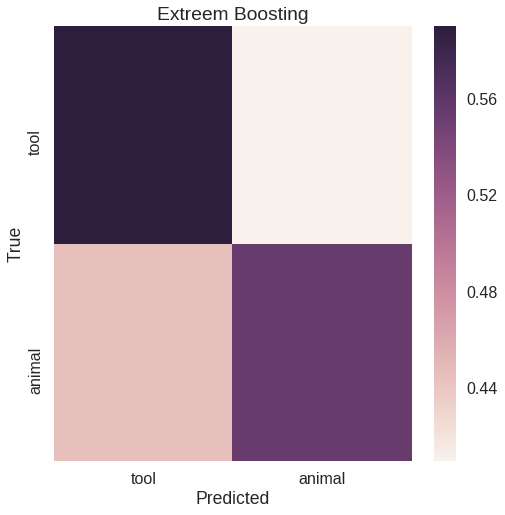

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm,ax=ax)
ax.set(ylabel = 'True', xlabel = 'Predicted',title = 'Extreem Boosting')

In [13]:
bst                   = xgb.XGBClassifier(max_depth = 7, 
                                              n_estimators = 200, 
                                              learning_rate = 0.05,
                                              subsample = 0.9,
                                              random_state = 12345,
                                              reg_alpha = 1e-4, 
                                              reg_lambda = 1e-4, 
                                              booster = 'gbtree',
                                              objective = 'binary:logistic')
full_data = MinMaxScaler().fit_transform(dataset.samples.astype('float32'))
full_labels = np.array([label_map[item] for item in dataset.sa.targets])[:,-1]
bst.fit(full_data,full_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=12345, reg_alpha=0.0001, reg_lambda=0.0001,
       scale_pos_weight=1, seed=None, silent=True, subsample=0.9)

In [0]:
feature_importance_norm = (bst.feature_importances_ - bst.feature_importances_.mean()) / bst.feature_importances_.std()

Text(0,0.5,u'Importance')

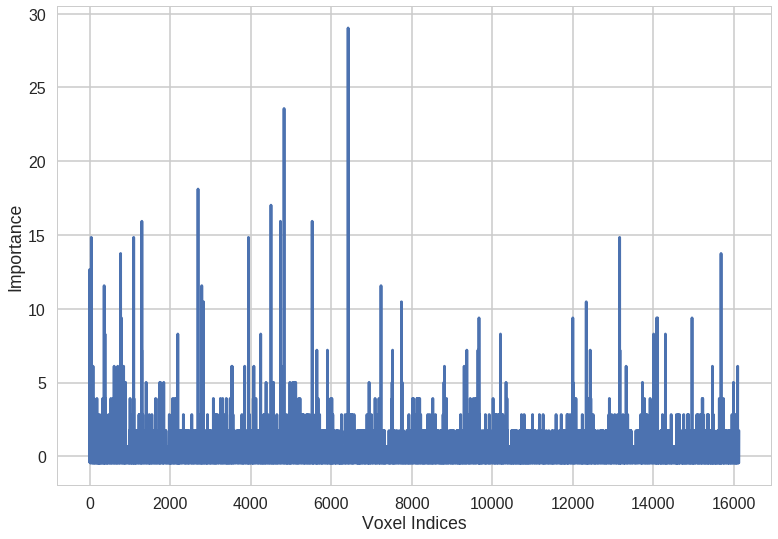

In [18]:
plt.plot(feature_importance_norm)
plt.xlabel('Voxel Indices')
plt.ylabel('Importance')

In [17]:
bst.score(full_data,full_labels)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1.0